In [12]:
%load_ext autoreload
%autoreload 2

import warnings
import os 
warnings.filterwarnings('ignore') 

from matplotlib import pyplot as plt 
from sklearn.gaussian_process.kernels import WhiteKernel, ConstantKernel, Matern
from sklearn.preprocessing import MinMaxScaler
import numpy as np

os.chdir("/Users/satya/Documents/sklearn-bax/")
plt.style.use("mpl_style/matplotlib.rc")

from src.utils import XY_from_csv, random_sampling_no_replace
from src.acquisition import run_acquisition
from src.algorithms import MultiRegionSetUnion, MultiRegionSetIntersection, GlobalOptimization1D, ParetoFront, Wishlist
from src.models import MGPR, fit_hypers
from src.metrics import get_n_obtained, get_jaccard_posterior
from src.plotting import plot_final_metrics, plot_iteration_results


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
X, Y = XY_from_csv("datasets/ssrl_ternary.csv", columns_x=["c_Fe", "c_Co"], columns_y=["coer", "kerr"])

x_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(-1, 1))

scalers = [x_scaler, y_scaler]

X = x_scaler.fit_transform(X)
Y = y_scaler.fit_transform(Y)

n_features = X.shape[1]
n_properties = Y.shape[1]

# handles one-property measurements
if len(Y.shape) == 1:
    Y = Y.reshape(-1, 1)

In [14]:
# algorithm = MultiRegionSetIntersection(threshold_list = [[2.0, 4.0], [0.3, 0.4]], scalers = scalers)
algorithm = Wishlist(
    threshold_bounds=[[[0.0, 2.0], [0.0, 0.2]], [[3.0, 4.0], [0.3, 0.4]], [[8.0, 10.0], [0.0, 0.1]]], scalers=scalers
)
# algorithm = ParetoFront(tolerance_list = [0.05, 0.01],  max_or_min_list = [1, 1], scalers = scalers)

In [15]:
all_ids = list(np.arange(0, len(X)))  # integer mapping design space
true_target_ids = algorithm.identify_subspace(
    x=X, y=Y
)  # ground truth set of design points which achieve experimental goal

In [16]:
plotting = True
prevent_requery = True
plot_frequency = 300
n_posterior_samples = 20
n_initial = 1
n_iters = 301
n_repeats = 3
fixed_hypers = True
adaptive_fit_freq = 10

kernel_initial = ConstantKernel(constant_value=1.0, constant_value_bounds=[0.01, 2.0]) * Matern(
    nu=5 / 2, length_scale=[0.5, 0.5], length_scale_bounds=2 * [[0.01, 2.0]]
) + WhiteKernel(noise_level=0.01, noise_level_bounds=[0.0001, 0.1])
kernel_initial_list = n_properties * [kernel_initial]

100%|█████████▉| 300/301 [09:56<00:02,  2.97s/it]

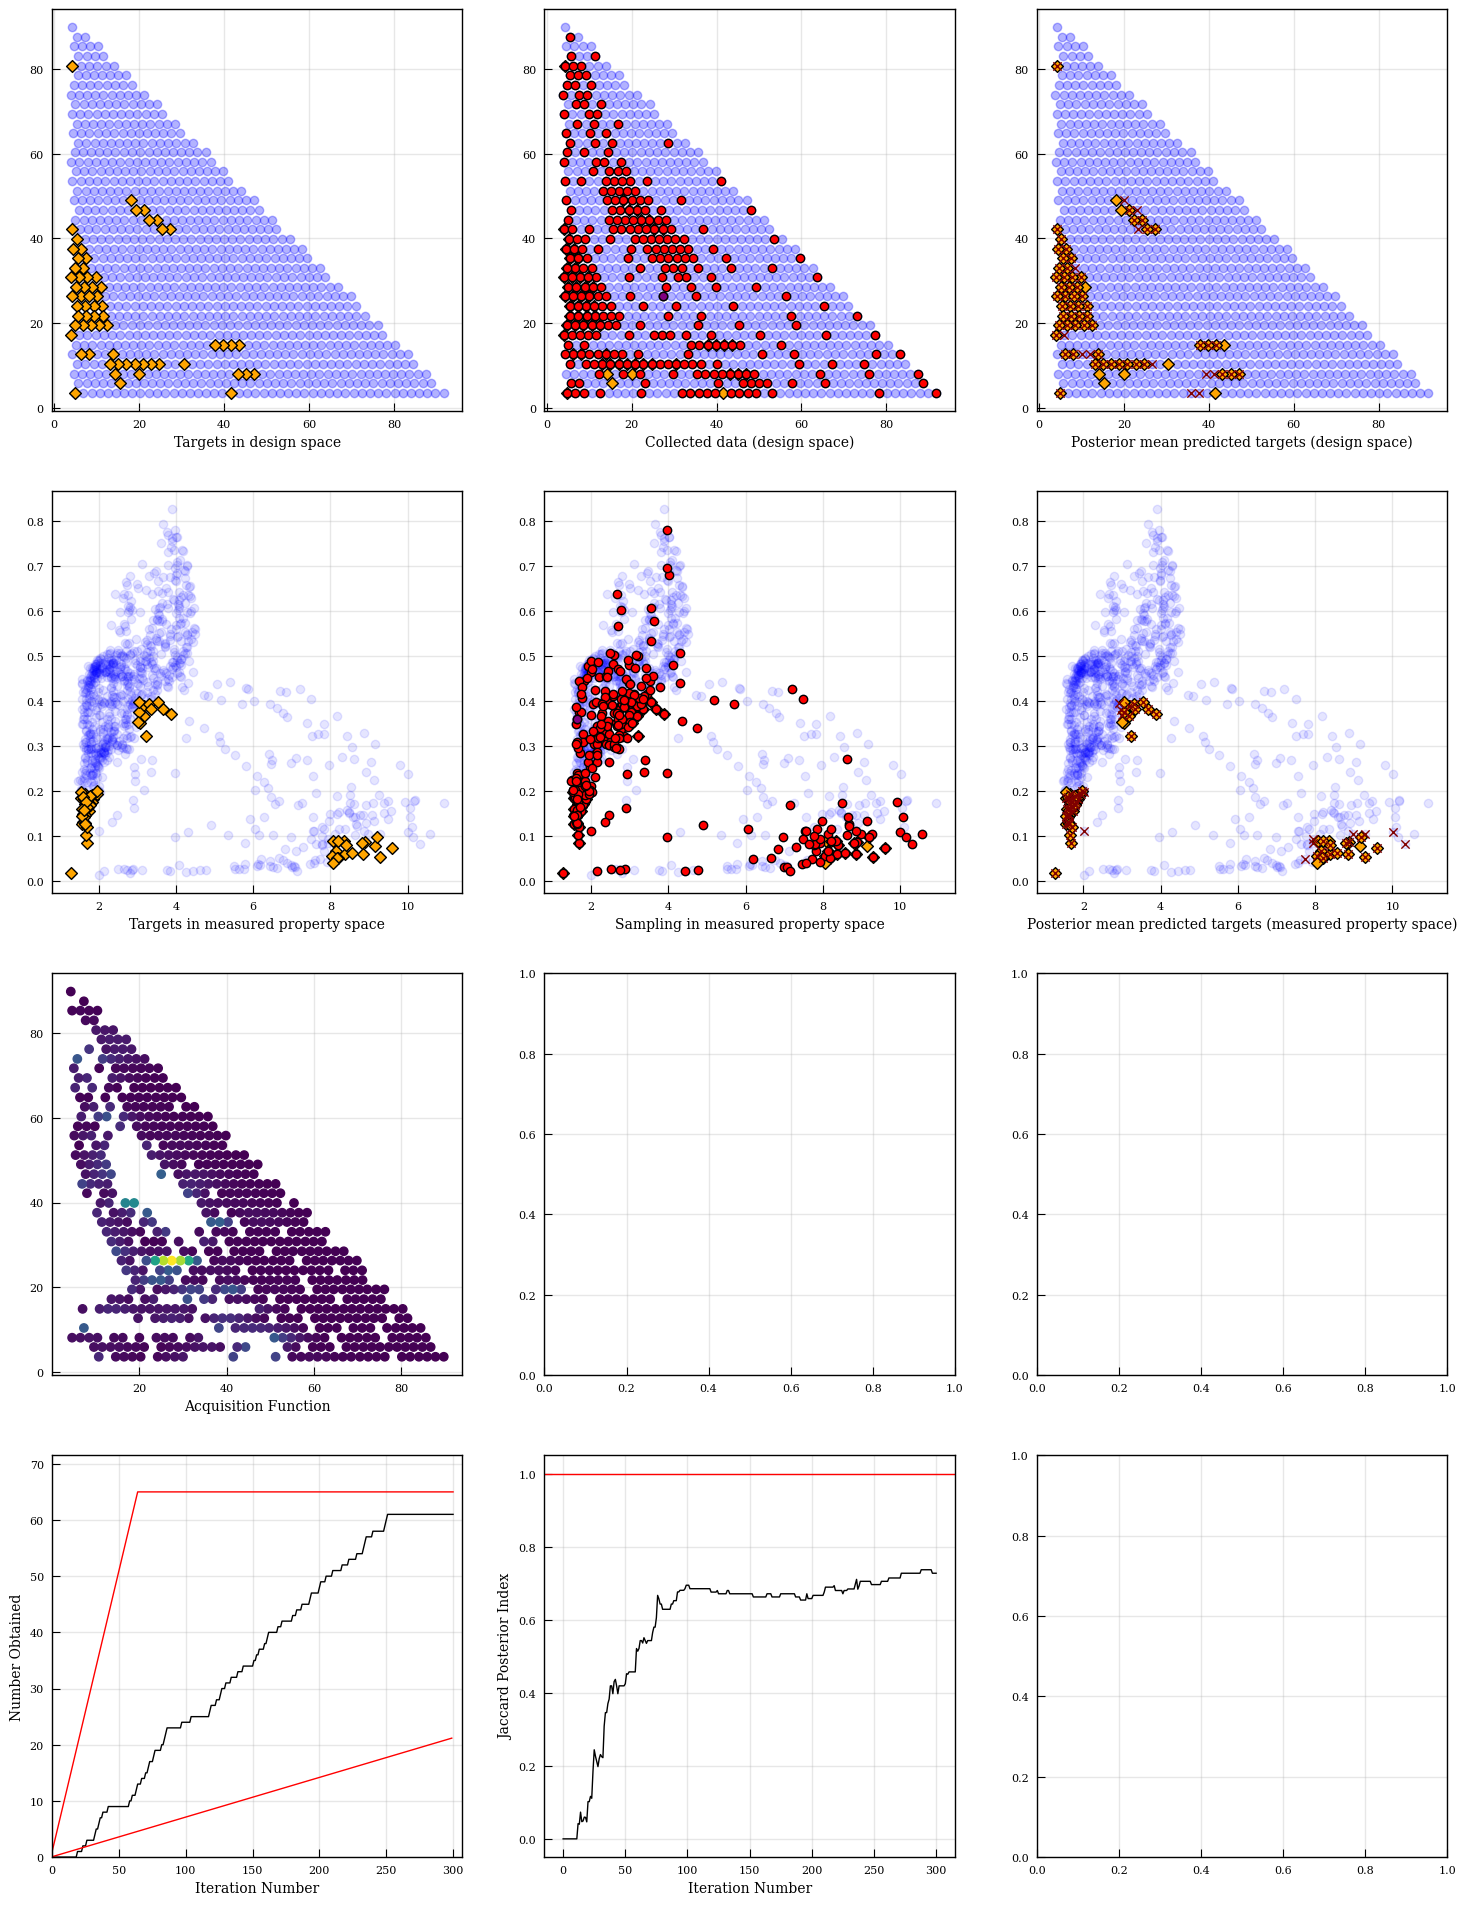

 62%|██████▏   | 186/301 [06:40<04:46,  2.49s/it]

In [17]:
from tqdm import tqdm

metrics = {
    "mixed": {"n_obtained": [], "jaccard_posterior_index": []},
    "meanbax": {"n_obtained": [], "jaccard_posterior_index": []},
    "infobax": {"n_obtained": [], "jaccard_posterior_index": []},
}


# Baseling for random sampling without replacement
random_sampling = [random_sampling_no_replace(len(X), len(true_target_ids), n) for n in range(n_initial, n_iters)]

# Baseline for best possible acquisition (i.e. acquire a target point at each iteration; need an "oracle" to do this)
if n_iters <= len(true_target_ids):
    best_possible_n_obtained = np.arange(n_initial, n_iters + n_initial)
else:
    best_possible_n_obtained = list(np.arange(n_initial, len(true_target_ids))) + list(
        len(true_target_ids) * np.ones(n_iters + n_initial - len(true_target_ids))
    )

# Acquisition functions that use BAX for subset estimation
strategies = ["infobax", "mixed", "meanbax"]

# Calculate hypers based on the entire dataset; this is not possible in a real experiment but allows us to compare acquisition fn to acquisition fn
if fixed_hypers:
    kernel_list = fit_hypers(x_train=X, y_train=Y, kernel_list=kernel_initial_list, n_restarts_optimizer=1)

for strategy in strategies:
    for j in range(n_repeats):  # to see variance w.r.t initial datapoint choice
        np.random.seed(j)
        train_indices = list(np.random.choice(all_ids, n_initial))
        x_train = X[train_indices]
        y_train = Y[train_indices]

        collected_ids = list(train_indices)
        n_obtained_list = []
        jaccard_posterior_list = []

        for i in tqdm(range(n_iters)):
            # Adaptive hyperparameter fitting
            if (i % adaptive_fit_freq == 0) and (fixed_hypers == False):
                kernel_list = fit_hypers(x_train=x_train, y_train=y_train, kernel_list=kernel_initial_list)

            # Define GP model with fixed, fitted hypers. Note, we need this to be fixed so that all the n_posterior models for InfoBAX have the same kernel
            multi_gpr = MGPR(kernel_list=kernel_list)

            # Acquire next index
            x_train, y_train, model, collected_ids, acquisition_function = run_acquisition(
                x_train, y_train, X, Y, strategy, algorithm, multi_gpr, collected_ids, n_posterior_samples
            )

            # Calculate metrics
            posterior_mean, posterior_std = model.predict(X)
            predicted_target_ids = algorithm.identify_subspace(x=X, y=posterior_mean)
            n_obtained_list.append(get_n_obtained(collected_ids, true_target_ids))
            jaccard_posterior_list.append(get_jaccard_posterior(predicted_target_ids, true_target_ids))

            if (i % plot_frequency == 0) and (plotting) and (i != 0):
                plot_iteration_results(
                    X,
                    Y,
                    x_scaler,
                    y_scaler,
                    collected_ids,
                    true_target_ids,
                    predicted_target_ids,
                    acquisition_function,
                    n_obtained_list,
                    jaccard_posterior_list,
                    best_possible_n_obtained,
                    random_sampling,
                )

        metrics[strategy]["n_obtained"].append(n_obtained_list)
        metrics[strategy]["jaccard_posterior_index"].append(jaccard_posterior_list)

plot_final_metrics(n_iters, metrics, strategies, best_possible_n_obtained, random_sampling)